# Hourly Time Series Forecasting using Facebook's Prophet

# Background on the Types of Time Series Data
![img](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

In [32]:
# !pip install pystan
# !pip install numpy
# !pip install pandas
# !pip install matplotlib

In [33]:
# !pip install convertdate
# !pip install lunarcalendar
# !pip install pystan
# !pip install prophet

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumption has some unique characteristics. It will be interesting to see how prophet picks them up.
 
Pulling the `PJM East` which has data from 2002-2018 for the entire east region.
 

In [35]:
pjme = pd.read_csv('PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


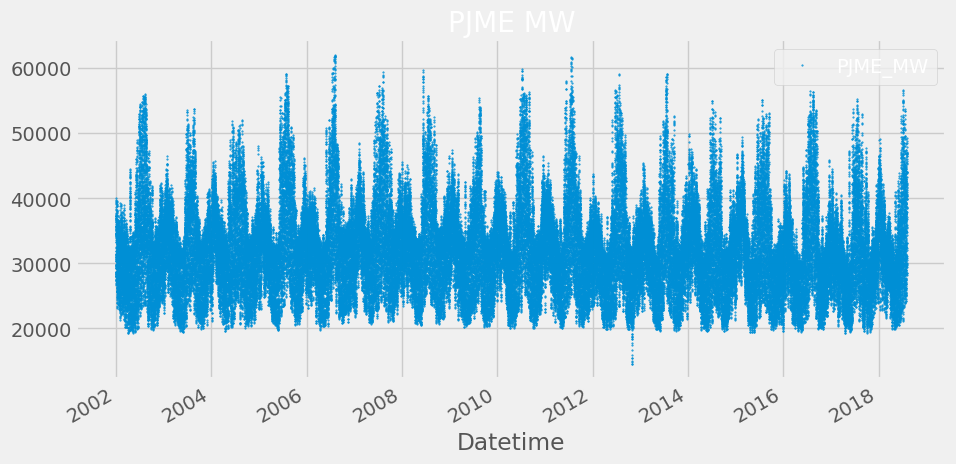

In [36]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

# Time Series Features

In [37]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

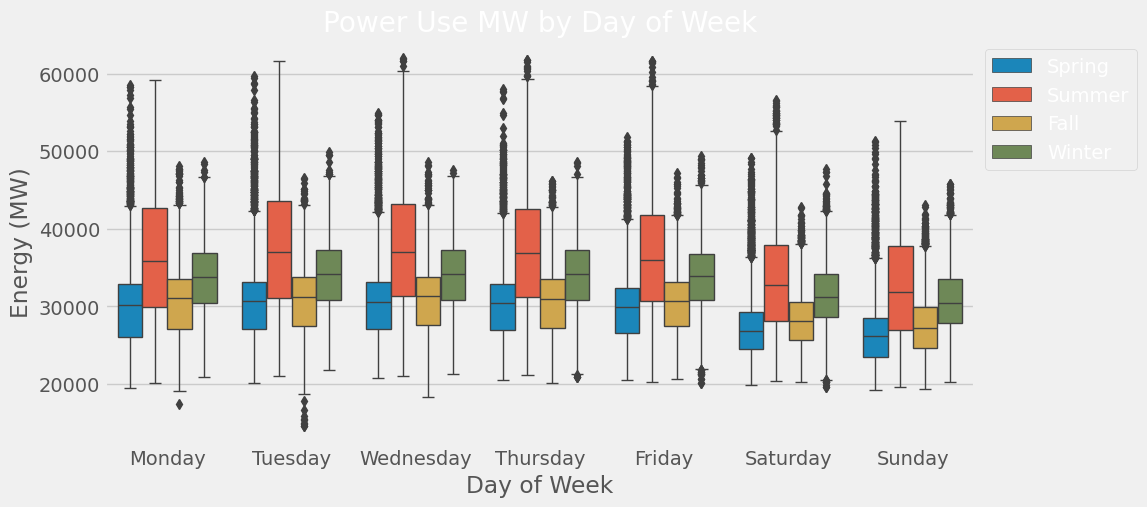

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot to visualize power use by day of week and season
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',            # x-axis represents the day of the week
            y='PJME_MW',            # y-axis represents the power use (MW)
            hue='season',           # different seasons represented by different colors
            ax=ax,                  # specify the axes for the plot
            linewidth=1)            # set the linewidth for better visibility of boxes

# Set plot title and axis labels
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')

# Add legend outside the plot for better visibility
ax.legend(bbox_to_anchor=(1, 1))

# Show the plot
plt.show()


# Train / Test Split

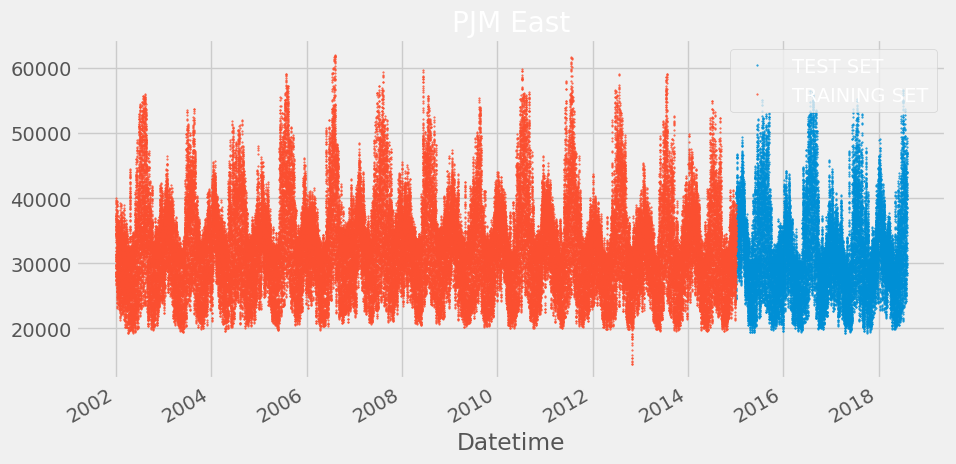

In [39]:
# Specify the split date
split_date = '1-Jan-2015'

# Create training set (data up to and including the split date)
pjme_train = pjme.loc[pjme.index <= split_date].copy()

# Create test set (data after the split date)
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot the training and test sets to visualize the split
pjme_test.rename(columns={'PJME_MW': 'TEST SET'})\
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer')\
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)  # Plot with dots for each data point
plt.show()


# Simple Prophet Model
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
    - Datetime column named: `ds`
    - target : `y`

In [40]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [41]:
pjme_train_prophet.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [42]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

23:01:05 - cmdstanpy - INFO - Chain [1] start processing
23:01:42 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 5.15 s, sys: 145 ms, total: 5.3 s
Wall time: 43.2 s


In [43]:
# Reset the index of the test set and rename columns for Prophet compatibility
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'})

# Use the Prophet model to predict on the test set
pjme_test_fcst = model.predict(pjme_test_prophet)

In [44]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.530967,23740.259508,32712.972691,31210.530967,31210.530967,-2893.742472,-2893.742472,-2893.742472,-4430.272423,...,1281.328732,1281.328732,1281.328732,255.201219,255.201219,255.201219,0.0,0.0,0.0,28316.788495
1,2015-01-01 02:00:00,31210.494154,22122.115663,30908.624089,31210.494154,31210.494154,-4398.239425,-4398.239425,-4398.239425,-5927.272577,...,1272.574102,1272.574102,1272.574102,256.459050,256.459050,256.459050,0.0,0.0,0.0,26812.254729
2,2015-01-01 03:00:00,31210.457342,21347.235566,30253.480380,31210.457342,31210.457342,-5269.974485,-5269.974485,-5269.974485,-6790.346308,...,1262.613389,1262.613389,1262.613389,257.758434,257.758434,257.758434,0.0,0.0,0.0,25940.482857
3,2015-01-01 04:00:00,31210.420529,21613.316736,30300.778120,31210.420529,31210.420529,-5411.456410,-5411.456410,-5411.456410,-6922.126021,...,1251.570211,1251.570211,1251.570211,259.099400,259.099400,259.099400,0.0,0.0,0.0,25798.964119
4,2015-01-01 05:00:00,31210.383716,21692.182982,31007.458267,31210.383716,31210.383716,-4737.018106,-4737.018106,-4737.018106,-6237.080479,...,1239.580401,1239.580401,1239.580401,260.481971,260.481971,260.481971,0.0,0.0,0.0,26473.365610


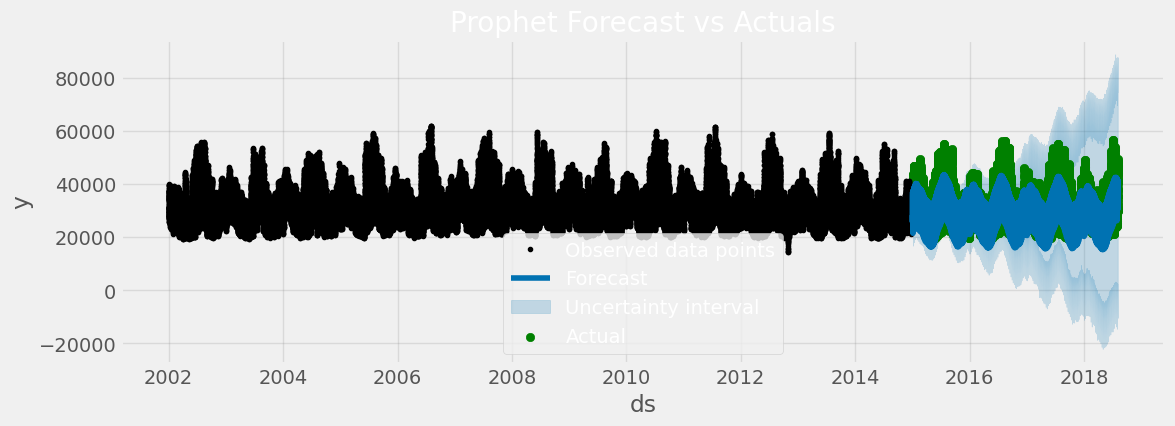

In [45]:
# Create a subplot with a specified size
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the Prophet forecast
fig = model.plot(pjme_test_fcst, ax=ax)

# Scatter plot for actuals (in red)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='g', label='Actual')

# Set the title of the plot
ax.set_title('Prophet Forecast vs Actuals')

# Add legend for better clarity
ax.legend()

# Display the plot
plt.show()


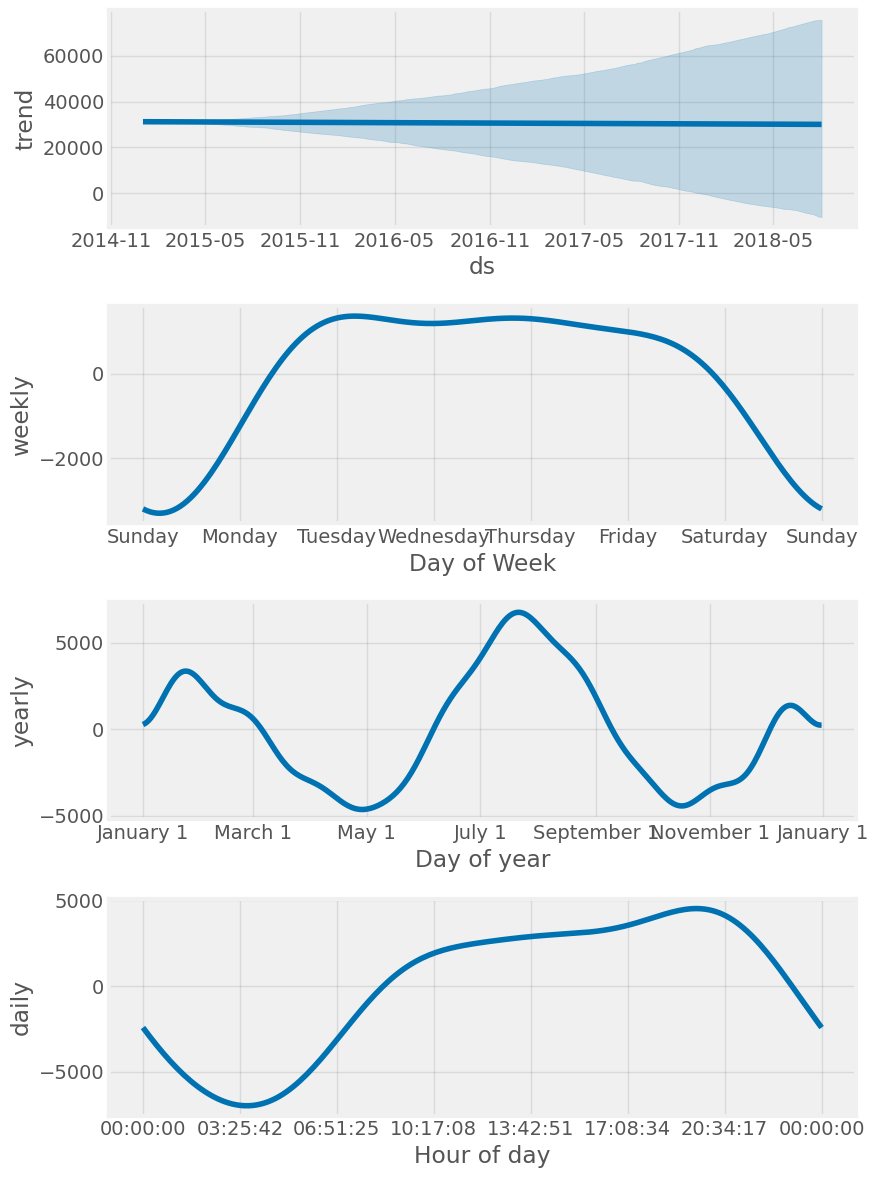

In [46]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

# Compare Forecast to Actuals

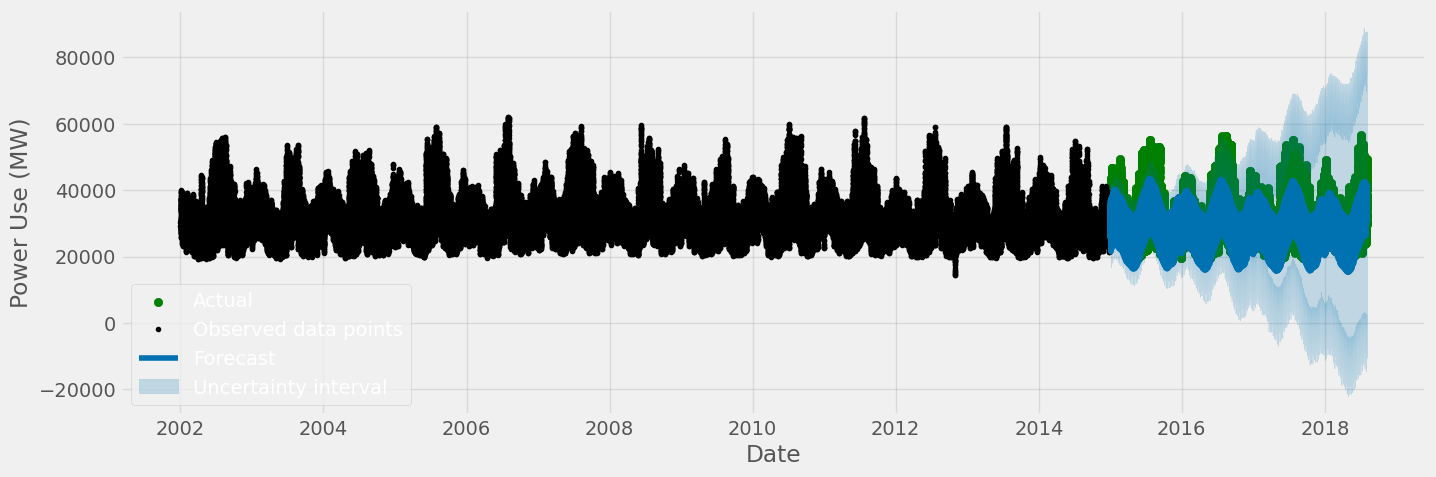

In [47]:
# Create a subplot with a specified size
f, ax = plt.subplots(figsize=(15, 5))

# Scatter plot for actuals (in red) with a label
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='g', label='Actual')

# Plot the Prophet forecast on the same axis
fig = model.plot(pjme_test_fcst, ax=ax, plot_cap=False, xlabel='Date', ylabel='Power Use (MW)')

# Add a legend for clarity
ax.legend()

# Display the plot
plt.show()


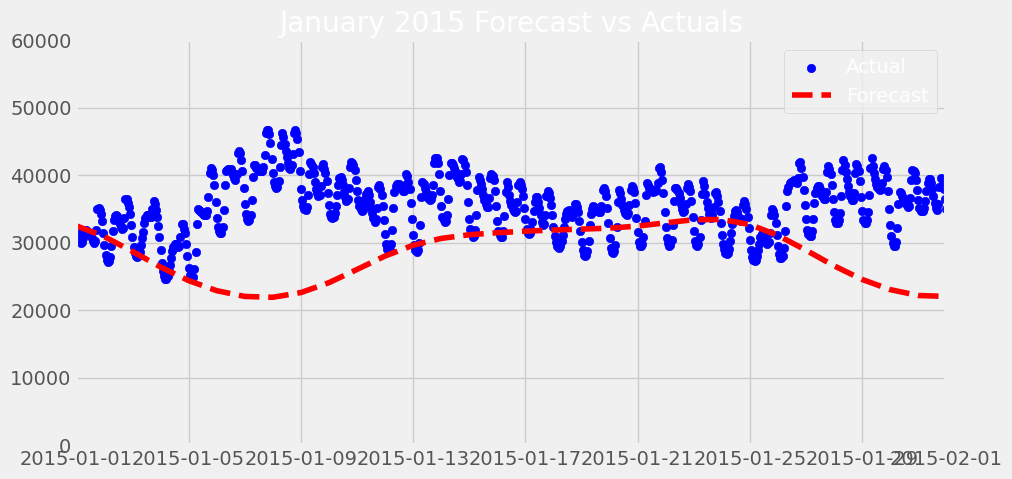

In [48]:
# Create a subplot with a specified size
fig, ax = plt.subplots(figsize=(10, 5))

# Scatter plot for actuals (in red)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='b', label='Actual')

# Line plot for the forecast (in blue, with dashed line style)
ax.plot(pjme_test_fcst.index, pjme_test_fcst['yhat'], label='Forecast', linestyle='--', color='r')

# Set x-axis limits and y-axis limits
ax.set_xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2015-02-01'))
ax.set_ylim(0, 60000)

# Add legend for better clarity
ax.legend()

# Set the title of the plot
plt.title('January 2015 Forecast vs Actuals')

# Display the plot
plt.show()


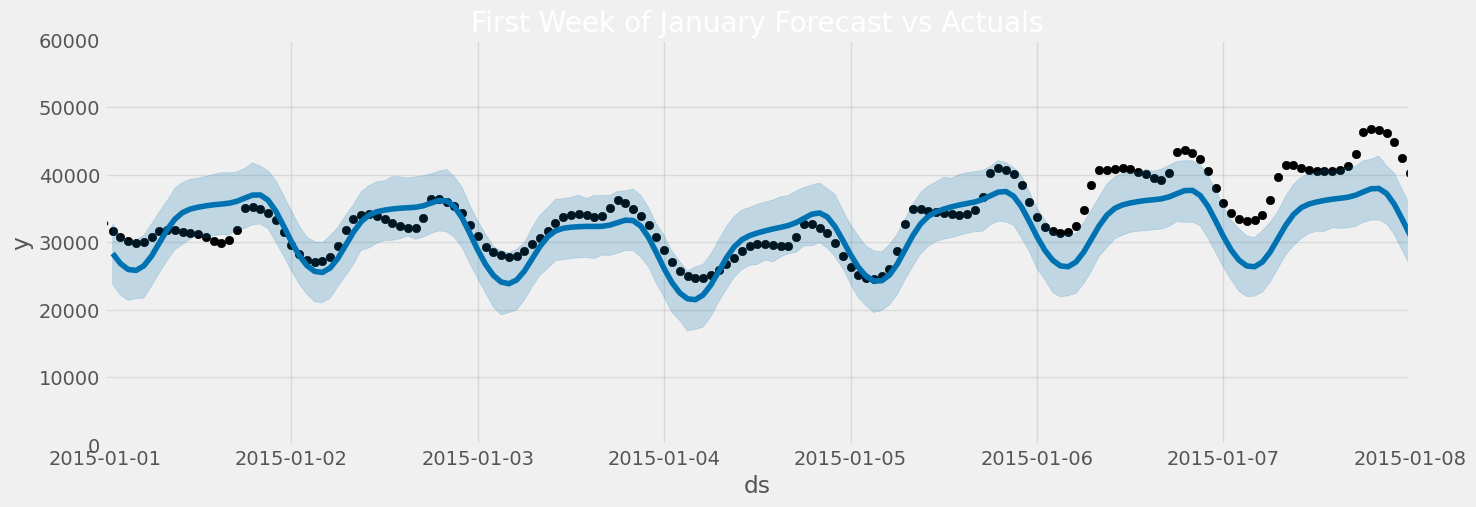

In [49]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))

# Scatter plot for actuals (in red)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='black')

# Plot the Prophet forecast on the same axis
model.plot(pjme_test_fcst, ax=ax)

# Set x-axis limits using pd.to_datetime
ax.set_xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2015-01-08'))

# Set y-axis limits
ax.set_ylim(0, 60000)

# Set the title of the plot
ax.set_title('First Week of January Forecast vs Actuals')

# Display the plot
plt.show()


# Evaluate the model with Error Metrics

In [50]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

6616.966074225221

In [51]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5181.911537928106

In [52]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.512003880182647

# Adding Holidays

Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [53]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Create a calendar of US federal holidays
cal = calendar()

# Get a DataFrame with dates and corresponding holiday names
holidays = cal.holidays(start=pjme.index.min(), end=pjme.index.max(), return_name=True)

# Create a DataFrame with 'ds' (date) and 'holiday' columns
holiday_df = pd.DataFrame(data=holidays, columns=['holiday'])

# Reset the index and rename columns for consistency
holiday_df = holiday_df.reset_index().rename(columns={'index': 'ds'})


In [54]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

23:01:59 - cmdstanpy - INFO - Chain [1] start processing
23:02:57 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 6.09 s, sys: 160 ms, total: 6.25 s
Wall time: 1min 4s


In [55]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

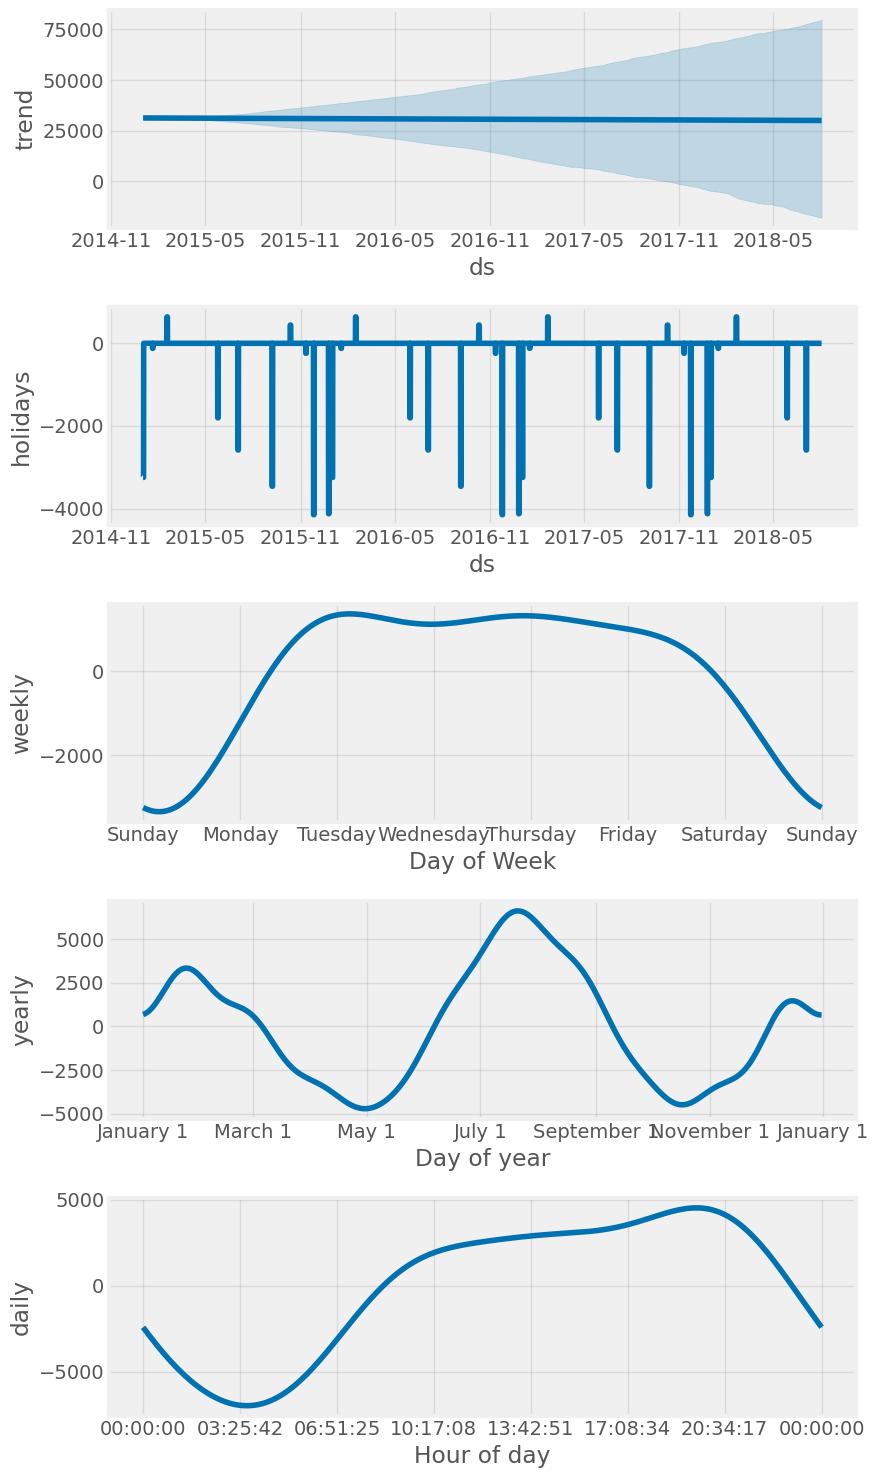

In [56]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

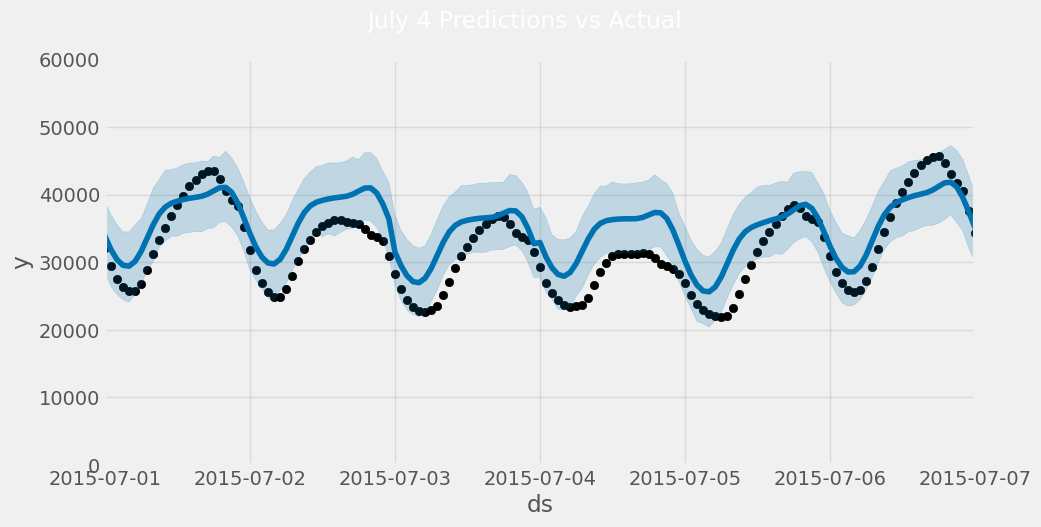

In [57]:
# Plot predictions vs actuals for a specific date range
fig, ax = plt.subplots(figsize=(10, 5))

# Scatter plot for actuals (in red)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='black')

# Plot the Prophet forecast on the same axis
model.plot(pjme_test_fcst_with_hols, ax=ax)

# Set x-axis limits using pd.to_datetime for the specified date range
ax.set_xlim(pd.to_datetime('2015-07-01'), pd.to_datetime('2015-07-07'))

# Set y-axis limits
ax.set_ylim(0, 60000)

# Add a title to the plot
plt.suptitle('July 4 Predictions vs Actual')

# Display the plot
plt.show()

In [58]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

6639.587205626055

In [59]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5201.46462763833

In [60]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

16.558807523531467

# Predict into the Future

We can use the built in `make_future_dataframe` method to build our future dataframe and make predictions.

In [61]:
# Assuming 'model_with_holidays' is your Prophet model with holidays
# Generate a future DataFrame for forecasting
future = model_with_holidays.make_future_dataframe(periods=365*24, freq='h', include_history=False)

# Use the model to make predictions on the future DataFrame
forecast = model_with_holidays.predict(future)


In [62]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,25567.271675
1,2015-01-01 02:00:00,24065.351481
2,2015-01-01 03:00:00,23195.828972
3,2015-01-01 04:00:00,23056.212620
4,2015-01-01 05:00:00,23732.192245


# The End